# Source water dynamics during upwelling and downwelling

In [1]:
import xarray as xr
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
def wm_day_divide(mydata):
    start = 2401
    length =int((np.max(mydata.init_t)-start+1)/24)

    bdy_loo = 0
    bdy_sou = 2
    bdy_off = 3
    bdy_nor = 4

    saltdiv = 32
    sdiv = 33.5

    fresh = [np.sum(mydata.final_transp[(mydata.final_section==bdy_sou) & (mydata.final_salt < saltdiv) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    cuc = [np.sum(mydata.final_transp[(mydata.final_section==bdy_sou) & (mydata.final_salt >= sdiv) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    south = [np.sum(mydata.final_transp[(mydata.final_section==bdy_sou) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)  & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    north = [np.sum(mydata.final_transp[(mydata.final_section==bdy_nor) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    offshore_d = [np.sum(mydata.final_transp[(mydata.final_section==bdy_off) & (mydata.final_depth > 120) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    offshore_s = [np.sum(mydata.final_transp[(mydata.final_section==bdy_off) & (mydata.final_depth <=120) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    
    loop = [np.sum(mydata.final_transp[(mydata.final_section==bdy_loo) & (abs(mydata.init_t-mydata.final_t) > 24) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
 
    return fresh, cuc, south, north, offshore_d, offshore_s, loop

def transport_df(data, start, length, years):
    # Create a master dataFrame to hold all the transport data, sorted by year day
    # data = list of transport arrays (from wm_day_divide) 
    # start = list of dt.datetime start days (start of season, not start of ariane run)
    # length = list of interger season length

    transport_data = pd.DataFrame()

    # Loop through each year's data and add it to the master dataFrame
    for year, start, season_length, transport in zip(years, startday, length, data):
        # Generate dates for the season
        dates = [start + dt.timedelta(days=x) for x in range(season_length)]
        
        # Extract month, day, and yearday
        # month = [date.month for date in dates]
        # day = [date.day for date in dates]
        yearday = [date.timetuple().tm_yday for date in dates]
        
        # Create a temporary dataFrame
        temp_df = pd.DataFrame({
            'yearday': yearday,
            f'transport_{year}': transport  # Transport column named by year
        })
        
        # Merge with the master dataFrame on 'month', 'day', and 'yearday'
        if transport_data.empty:
            transport_data = temp_df
        else:
            transport_data = pd.merge(transport_data, temp_df, on=['yearday'], how='outer')

        # Sort by yearday for better organization
        transport_data = transport_data.sort_values(by=['yearday']).reset_index(drop=True)

    return transport_data

## Upwelling

In [3]:
df23 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20230922/ariane_positions_quantitative.nc')
df22 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20221015/ariane_positions_quantitative.nc')
df21 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20210922/ariane_positions_quantitative.nc')
df20 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20201017/ariane_positions_quantitative.nc')
df19 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20191105/ariane_positions_quantitative.nc')
df18 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20180906/ariane_positions_quantitative.nc')
df17 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20171012/ariane_positions_quantitative.nc')
df16 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20160913/ariane_positions_quantitative.nc')
df15 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20150905/ariane_positions_quantitative.nc')
df14 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20140903/ariane_positions_quantitative.nc')
# df13 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20131024/ariane_positions_quantitative.nc') # don't include bc we don't have a full year

In [5]:
fresh23, cuc23, south23, north23, offshore_d23, offshore_s23, loop23 = wm_day_divide(df23)
fresh22, cuc22, south22, north22, offshore_d22, offshore_s22, loop22 = wm_day_divide(df22)
fresh21, cuc21, south21, north21, offshore_d21, offshore_s21, loop21 = wm_day_divide(df21)
fresh20, cuc20, south20, north20, offshore_d20, offshore_s20, loop20 = wm_day_divide(df20)
fresh19, cuc19, south19, north19, offshore_d19, offshore_s19, loop19 = wm_day_divide(df19)
fresh18, cuc18, south18, north18, offshore_d18, offshore_s18, loop18 = wm_day_divide(df18)
fresh17, cuc17, south17, north17, offshore_d17, offshore_s17, loop17 = wm_day_divide(df17)
fresh16, cuc16, south16, north16, offshore_d16, offshore_s16, loop16 = wm_day_divide(df16)
fresh15, cuc15, south15, north15, offshore_d15, offshore_s15, loop15 = wm_day_divide(df15)
fresh14, cuc14, south14, north14, offshore_d14, offshore_s14, loop14 = wm_day_divide(df14)
# fresh13, cuc13, south13, north13, offshore_d13, offshore_s13, loop13 = wm_day_divide(df13)


In [6]:
endday = [dt.datetime(2014, 9, 3), 
            dt.datetime(2015, 9, 5), dt.datetime(2016, 9, 13), 
            dt.datetime(2017, 10, 12), dt.datetime(2018, 9, 6), 
             dt.datetime(2019, 11, 5), dt.datetime(2020, 10, 17),
            dt.datetime(2021, 9, 22), dt.datetime(2022, 10, 15),
            dt.datetime(2023,9,22)]  # Start dates dt.datetime(2013, 10, 24), 
length = [161, 144, 158, 156,128,193,244,189, 117,136]  # Number of days in the season for each year #219
startday = [endday[i]-dt.timedelta(days=length[i]) for i in range(len(endday))]  # Start dates

In [7]:
fresh = transport_df([fresh14, fresh15, fresh16, fresh17, fresh18, fresh19, fresh20,fresh21,fresh22,fresh23], startday, length,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
south = transport_df([south14, south15, south16, south17, south18, south19, south20,south21,south22,south23], startday, length,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
north = transport_df([north14, north15, north16, north17, north18, north19, north20,north21,north22,north23], startday, length,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
cuc = transport_df([cuc14, cuc15, cuc16, cuc17, cuc18, cuc19, cuc20,cuc21,cuc22,cuc23], startday, length,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
offshore_d = transport_df([offshore_d14, offshore_d15, offshore_d16, offshore_d17, offshore_d18, offshore_d19, offshore_d20,offshore_d21,offshore_d22,offshore_d23], startday, length,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
offshore_s = transport_df([offshore_s14, offshore_s15, offshore_s16, offshore_s17, offshore_s18, offshore_s19, offshore_s20,offshore_s21,offshore_s22,offshore_s23], startday, length,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
loop = transport_df([loop14, loop15, loop16, loop17, loop18, loop19, loop20,loop21,loop22,loop23], startday, length,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])

In [8]:
# Add a count column to track the number of transport columns with data
# doing this with loop flow bc there will always be loop flow
transport_columns = [col for col in loop.columns if col.startswith('transport_')]
loop['count'] = loop[transport_columns].notna().sum(axis=1)

In [9]:
# number of similations overallaping in a julianne day
# can't do it the same way as in upwelling bc downwelling too erratic 
jsta = [date.timetuple().tm_yday for date in startday]
jend =[date.timetuple().tm_yday for date in endday]

UPcounts = np.zeros(np.max(jend)-np.min(jsta)+1)
jul = (np.arange(np.min(jsta),np.max(jend)+1))

for i in range(len(UPcounts)):
    for j in range(len(jsta)):
        if jul[i] >= jsta[j] and jul[i] <= jend[j]:
            UPcounts[i]+=1

In [10]:
# date range where all years overlap 
jul[UPcounts == np.max(UPcounts)]
# 171 = June 20
# 246 = September 3

array([171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
       197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
       210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
       223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
       236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246])

In [11]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
window = 4

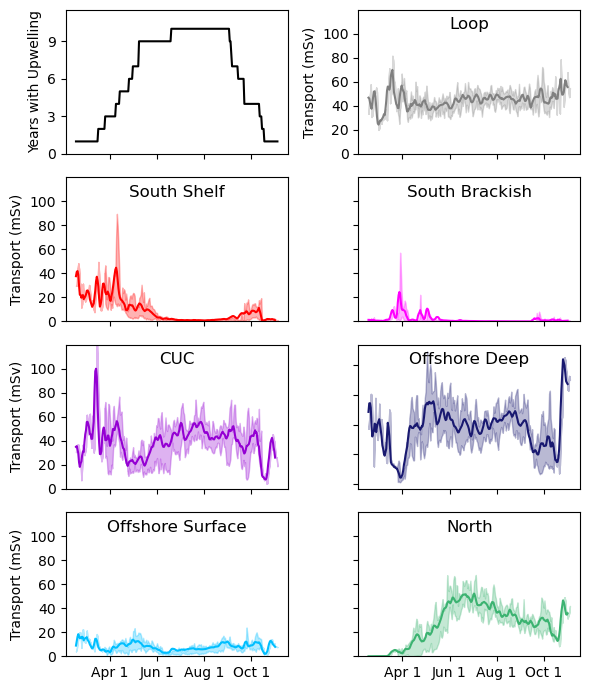

In [12]:
# using quantile

ymax=120000

fig, ax = plt.subplots(4,2, figsize=(6,7))

for i in range(4):
    for axs in ax[i]:
        axs.set_xticks([91,152,213,274])
for axs in [ax[0,1],ax[1,0],ax[2,0],ax[3,0]]:
    axs.set_yticks([0,20000,40000,60000,80000,100000])
    axs.set_yticklabels(['0','20','40','60','80','100'])
    axs.set_ylabel('Transport (mSv)')
for axs in [ax[1,1],ax[2,1],ax[3,1]]:
    axs.set_yticks([0,20000,40000,60000,80000,100000])
    axs.set_yticklabels([])
ax[3,0].set_xticklabels(['Apr 1','Jun 1', 'Aug 1','Oct 1'])
ax[3,1].set_xticklabels(['Apr 1','Jun 1', 'Aug 1','Oct 1'])

# count of the number of summers with this date in the range
ax[0,0].plot(jul,UPcounts,'k')
ax[0,0].set_ylabel("Years with Upwelling")
ax[0,0].set_ylim([0,11.5])
ax[0,0].set_yticks([0,3,6,9])
ax[0,0].set_xticklabels([])


# loop flow
Uloop = [loop.transport_2014,loop.transport_2015,loop.transport_2016,loop.transport_2017,loop.transport_2018,
        loop.transport_2019,loop.transport_2020,loop.transport_2021,loop.transport_2022,loop.transport_2023]
ax[0,1].plot(loop.yearday[:(-window + 1)],moving_average(np.nanmean(Uloop,axis=0),window),'grey')
ax[0,1].fill_between(loop.yearday,
                        np.nanpercentile(Uloop, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(Uloop, [75], method='midpoint',axis=0)[0],
                        color='grey',alpha=0.3)
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim([0,ymax])
ax[0,1].set_title('Loop',y=1,pad=-14)

# south shelf flow
# ax[1,0].plot(dates,mean_south)
Usouth = [south.transport_2014,south.transport_2015,south.transport_2016,south.transport_2017,south.transport_2018,
        south.transport_2019,south.transport_2020,south.transport_2021,south.transport_2022,south.transport_2023]
ax[1,0].plot(south.yearday[:(-window + 1)],moving_average(np.nanmean(Usouth,axis=0),window),'r')
ax[1,0].fill_between(south.yearday,
                        np.nanpercentile(Usouth, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(Usouth, [75], method='midpoint',axis=0)[0],
                        color='r',alpha=0.3)
ax[1,0].set_xticklabels([])
ax[1,0].set_ylim([0,ymax])
ax[1,0].set_title('South Shelf',y=1,pad=-14)


# fresh flow
# ax[1,1].plot(dates,mean_fresh)
Ufresh = [fresh.transport_2014, fresh.transport_2015,fresh.transport_2016,fresh.transport_2017,fresh.transport_2018,
        fresh.transport_2019,fresh.transport_2020,fresh.transport_2021,fresh.transport_2022,fresh.transport_2023]
ax[1,1].plot(fresh.yearday[:(-window + 1)],moving_average(np.nanmean(Ufresh,axis=0),window),'magenta')
ax[1,1].fill_between(fresh.yearday,
                        np.nanpercentile(Ufresh, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(Ufresh, [75], method='midpoint',axis=0)[0],
                        color='magenta',alpha=0.3)
ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])
ax[1,1].set_ylim([0,ymax])
ax[1,1].set_title('South Brackish',y=1,pad=-14)

# cuc flow
Ucuc = [cuc.transport_2014,cuc.transport_2015,cuc.transport_2016,cuc.transport_2017,cuc.transport_2018,
        cuc.transport_2019,cuc.transport_2020,cuc.transport_2021,cuc.transport_2022,cuc.transport_2023]
ax[2,0].plot(cuc.yearday[:(-window + 1)],moving_average(np.nanmean(Ucuc,axis=0),window),'darkviolet')
ax[2,0].fill_between(cuc.yearday,
                        np.nanpercentile(Ucuc, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(Ucuc, [75], method='midpoint',axis=0)[0],
                        color='darkviolet',alpha=0.3)
ax[2,0].set_xticklabels([])
ax[2,0].set_ylim([0,ymax])
ax[2,0].set_title('CUC',y=1,pad=-14)

# offshore deep flow
Uoffd = [offshore_d.transport_2014,offshore_d.transport_2015,offshore_d.transport_2016,offshore_d.transport_2017,offshore_d.transport_2018,
        offshore_d.transport_2019,offshore_d.transport_2020,offshore_d.transport_2021,offshore_d.transport_2022,offshore_d.transport_2023]
ax[2,1].plot(offshore_d.yearday[:(-window + 1)],moving_average(np.nanmean(Uoffd,axis=0),window),'midnightblue')
ax[2,1].fill_between(offshore_d.yearday,
                        np.nanpercentile(Uoffd, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(Uoffd, [75], method='midpoint',axis=0)[0],
                        color='midnightblue',alpha=0.3)
ax[2,1].set_title('Offshore Deep',y=1,pad=-14)
ax[2,1].set_yticklabels([])
ax[2,1].set_xticklabels([])



# offshore surface flow
Uoffs = [offshore_s.transport_2014,offshore_s.transport_2015,offshore_s.transport_2016,offshore_s.transport_2017,offshore_s.transport_2018,
        offshore_s.transport_2019,offshore_s.transport_2020,offshore_s.transport_2021,offshore_s.transport_2022,offshore_s.transport_2023]
ax[3,0].plot(offshore_s.yearday[:(-window + 1)],moving_average(np.nanmean(Uoffs,axis=0),window),'deepskyblue')
ax[3,0].fill_between(offshore_s.yearday,
                        np.nanpercentile(Uoffs, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(Uoffs, [75], method='midpoint',axis=0)[0],
                        color='deepskyblue',alpha=0.3)
# ax[3,0].set_xticklabels([])
ax[3,0].set_ylim([0,ymax])
ax[3,0].set_title('Offshore Surface',y=1,pad=-14)


# north flow
Unorth = [north.transport_2014,north.transport_2015,north.transport_2016,north.transport_2017,north.transport_2018,
        north.transport_2019,north.transport_2020,north.transport_2021,north.transport_2022,north.transport_2023]
ax[3,1].plot(north.yearday[:(-window + 1)],moving_average(np.nanmean(Unorth,axis=0),window),'mediumseagreen')
ax[3,1].fill_between(north.yearday,
                        np.nanpercentile(Unorth, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(Unorth, [75], method='midpoint',axis=0)[0],
                        color='mediumseagreen',alpha=0.3)
# ax[3,1].set_xticklabels([])
ax[3,1].set_ylim([0,ymax])
ax[3,1].set_title('North',y=1,pad=-14)
ax[3,1].set_yticklabels([])


plt.tight_layout()
plt.savefig('/data1/bbeutel/LO_user/ariane/figures/summer_dynamics.pdf')

## Downwelling

In [13]:
df22 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20230419/ariane_positions_quantitative.nc')
df21 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20220125/ariane_positions_quantitative.nc')
df20 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20210202/ariane_positions_quantitative.nc')
df19 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20200127/ariane_positions_quantitative.nc')
df18 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20190406/ariane_positions_quantitative.nc')
df17 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20180201/ariane_positions_quantitative.nc')
df16 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20170419/ariane_positions_quantitative.nc')
df15 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20160319/ariane_positions_quantitative.nc')
df14 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20150212/ariane_positions_quantitative.nc')
df13 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20140306/ariane_positions_quantitative.nc')


In [14]:
fresh22, cuc22, south22, north22, offshore_d22, offshore_s22, loop22 = wm_day_divide(df22)
fresh21, cuc21, south21, north21, offshore_d21, offshore_s21, loop21 = wm_day_divide(df21)
fresh20, cuc20, south20, north20, offshore_d20, offshore_s20, loop20 = wm_day_divide(df20)
fresh19, cuc19, south19, north19, offshore_d19, offshore_s19, loop19 = wm_day_divide(df19)
fresh18, cuc18, south18, north18, offshore_d18, offshore_s18, loop18 = wm_day_divide(df18)
fresh17, cuc17, south17, north17, offshore_d17, offshore_s17, loop17 = wm_day_divide(df17)
fresh16, cuc16, south16, north16, offshore_d16, offshore_s16, loop16 = wm_day_divide(df16)
fresh15, cuc15, south15, north15, offshore_d15, offshore_s15, loop15 = wm_day_divide(df15)
fresh14, cuc14, south14, north14, offshore_d14, offshore_s14, loop14 = wm_day_divide(df14)
fresh13, cuc13, south13, north13, offshore_d13, offshore_s13, loop13 = wm_day_divide(df13)

In [15]:
endday = [dt.datetime(2014, 3, 6), dt.datetime(2015, 2, 12), dt.datetime(2016, 3, 19),dt.datetime(2017, 4, 19), dt.datetime(2018, 2, 1),
          dt.datetime(2019, 4, 6), dt.datetime(2020, 1, 27),dt.datetime(2021, 2, 2), dt.datetime(2022, 1, 25),dt.datetime(2023,4,19)] 
length = [113, 143, 149, 198, 91, 163, 53, 82, 105,176]  # Number of days in the season for each year
startday = [endday[i]-dt.timedelta(days=length[i]) for i in range(len(endday))]  # Start dates

In [16]:
fresh = transport_df([fresh13, fresh14,fresh15,fresh16,fresh17,fresh18, fresh19,fresh20,fresh21,fresh22], startday, length,[2013,2014, 2015,2016,2017,2018,2019,2020,2021,2022])
south = transport_df([south13, south14,south15,south16,south17,south18, south19,south20,south21,south22], startday, length,[2013,2014, 2015,2016,2017,2018,2019,2020,2021,2022])
north = transport_df([north13, north14,north15,north16,north17,north18, north19,north20,north21,north22], startday, length,[2013,2014, 2015,2016,2017,2018,2019,2020,2021,2022])
cuc = transport_df([cuc13,cuc14,cuc15,cuc16,cuc17,cuc18, cuc19,cuc20,cuc21,cuc22], startday, length,[2013,2014, 2015,2016,2017,2018,2019,2020,2021,2022])
offshore_d = transport_df([offshore_d13, offshore_d14,offshore_d15,offshore_d16,offshore_d17,offshore_d18, offshore_d19,offshore_d20,offshore_d21,offshore_d22], startday, length,[2013,2014, 2015,2016,2017,2018,2019,2020,2021,2022])
offshore_s = transport_df([offshore_s13, offshore_s14,offshore_s15,offshore_s16,offshore_s17,offshore_s18, offshore_s19,offshore_s20,offshore_s21,offshore_s22], startday, length,[2013,2014, 2015,2016,2017,2018,2019,2020,2021,2022])
loop = transport_df([loop13,loop14,loop15,loop16,loop17,loop18, loop19,loop20,loop21,loop22], startday, length,[2013,2014, 2015,2016,2017,2018,2019,2020,2021,2022])

In [17]:
# number of similations overallaping in a julianne day
# can't do it the same way as in upwelling bc downwelling too erratic 
jsta = [date.timetuple().tm_yday for date in startday]
jend =[date.timetuple().tm_yday + 365 for date in endday]

DWcounts = np.zeros(np.max(jend)-np.min(jsta)+1)
jul = (np.arange(np.min(jsta),np.max(jend)+1))

for i in range(len(DWcounts)):
    for j in range(len(jsta)):
        if jul[i] >= jsta[j] and jul[i] <= jend[j]:
            DWcounts[i]+=1


In [18]:
# date range where all years overlap 
jul[DWcounts == np.max(DWcounts)]
# 339 = Dec 5
# 390 - 365 = 25 = January 25

array([339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390])

In [19]:
fresh.sort_values(by="yearday")
south.sort_values(by="yearday")
north.sort_values(by="yearday")
cuc.sort_values(by="yearday")
offshore_d.sort_values(by="yearday")
offshore_s.sort_values(by="yearday")
loop.sort_values(by="yearday")

# because its winter you need to add 365 to the dates January 1 onwards
fresh.loc[fresh.yearday<200,'yearday'] += 365
south.loc[south.yearday<200,'yearday'] += 365
north.loc[north.yearday<200,'yearday'] += 365
cuc.loc[cuc.yearday<200,'yearday'] += 365
offshore_d.loc[offshore_d.yearday<200,'yearday'] += 365
offshore_s.loc[offshore_s.yearday<200,'yearday'] += 365
loop.loc[loop.yearday<200,'yearday'] += 365

# and reorder
fresh.sort_values(by="yearday",inplace=True)
south.sort_values(by="yearday",inplace=True)
north.sort_values(by="yearday",inplace=True)
cuc.sort_values(by="yearday",inplace=True)
offshore_d.sort_values(by="yearday",inplace=True)
offshore_s.sort_values(by="yearday",inplace=True)
loop.sort_values(by="yearday",inplace=True)

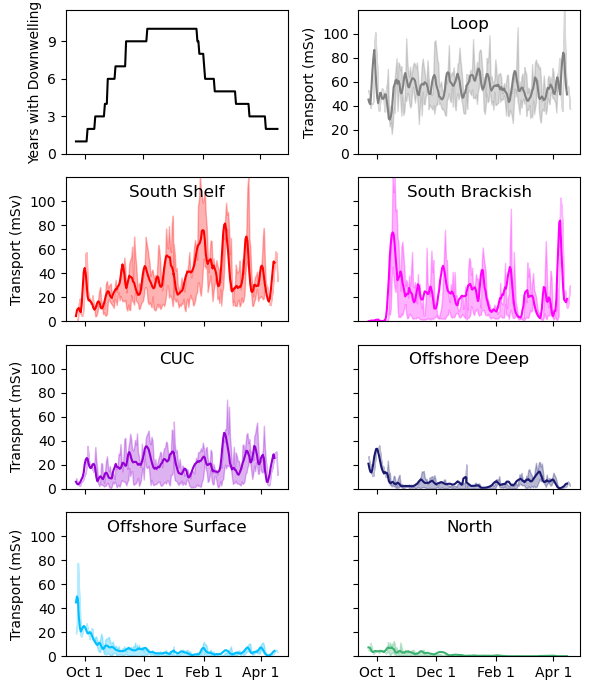

In [20]:
# using quantiles (previously std.. see github)
ymax=120000

fig, ax = plt.subplots(4,2, figsize=(6,7))

for axs in [ax[0,1],ax[1,0],ax[2,0],ax[3,0]]:
    axs.set_yticks([0,20000,40000,60000,80000,100000])
    axs.set_yticklabels(['0','20','40','60','80','100'])
    axs.set_ylabel('Transport (mSv)')
for axs in [ax[1,1],ax[2,1],ax[3,1]]:
    axs.set_yticks([0,20000,40000,60000,80000,100000])
    axs.set_yticklabels([])

for i in range(4):
    for axs in ax[i]:
        axs.set_xticks([274,335,397,456]) # october 1, december 1, february 1, april 1
ax[3,0].set_xticklabels(['Oct 1','Dec 1','Feb 1', 'Apr 1'])
ax[3,1].set_xticklabels(['Oct 1','Dec 1','Feb 1', 'Apr 1'])


# count of the number of summers with this date in the range
ax[0,0].plot(jul,DWcounts,'k')
ax[0,0].set_ylim([0,11.5])
ax[0,0].set_yticks([0,3,6,9])
ax[0,0].set_xticklabels([])
ax[0,0].set_ylabel("Years with Downwelling")

# loop flow
Dloop = [loop.transport_2013, loop.transport_2014, loop.transport_2015, loop.transport_2016,loop.transport_2017,loop.transport_2018, loop.transport_2019,
        loop.transport_2020,loop.transport_2021,loop.transport_2022]
ax[0,1].plot(loop.yearday[:(-window + 1)],moving_average(np.nanmean(Dloop,axis=0),window),'grey')
ax[0,1].fill_between(loop.yearday,
                        np.nanpercentile(Dloop, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(Dloop, [75], method='midpoint',axis=0)[0],
                        color='grey',alpha=0.3)
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim([0,ymax])
ax[0,1].set_title('Loop',y=1,pad=-14)

# south shelf flow
# ax[1,0].plot(dates,mean_south)
Dsouth = [south.transport_2013, south.transport_2014, south.transport_2015, south.transport_2016,south.transport_2017,south.transport_2018, south.transport_2019,
        south.transport_2020,south.transport_2021,south.transport_2022]
ax[1,0].plot(south.yearday[:(-window + 1)],moving_average(np.nanmean(Dsouth,axis=0),window),'r')
ax[1,0].fill_between(south.yearday,
                        np.nanpercentile(Dsouth, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(Dsouth, [75], method='midpoint',axis=0)[0],
                        color='r',alpha=0.3)
ax[1,0].set_xticklabels([])
ax[1,0].set_ylim([0,ymax])
ax[1,0].set_title('South Shelf',y=1,pad=-14)


# fresh flow
# ax[1,1].plot(dates,mean_fresh)
Dfresh = [fresh.transport_2013, fresh.transport_2014,fresh.transport_2015, fresh.transport_2016, fresh.transport_2017,fresh.transport_2018, fresh.transport_2019,
        fresh.transport_2020,fresh.transport_2021,fresh.transport_2022]
ax[1,1].plot(fresh.yearday[:(-window + 1)],moving_average(np.nanmean(Dfresh,axis=0),window),'magenta')
ax[1,1].fill_between(fresh.yearday,
                        np.nanpercentile(Dfresh, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(Dfresh, [75], method='midpoint',axis=0)[0],
                        color='magenta',alpha=0.3)
ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])
ax[1,1].set_ylim([0,ymax])
ax[1,1].set_title('South Brackish',y=1,pad=-14)

# cuc flow
Dcuc = [cuc.transport_2013, cuc.transport_2014, cuc.transport_2015, cuc.transport_2016,cuc.transport_2017,cuc.transport_2018, cuc.transport_2019,
        cuc.transport_2020,cuc.transport_2021,cuc.transport_2022]
ax[2,0].plot(cuc.yearday[:(-window + 1)],moving_average(np.nanmean(Dcuc,axis=0),window),'darkviolet')
ax[2,0].fill_between(cuc.yearday,
                        np.nanpercentile(Dcuc, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(Dcuc, [75], method='midpoint',axis=0)[0],
                        color='darkviolet',alpha=0.3)
ax[2,0].set_xticklabels([])
ax[2,0].set_ylim([0,ymax])
ax[2,0].set_title('CUC',y=1,pad=-14)

# offshore deep flow
Doofd = [offshore_d.transport_2013, offshore_d.transport_2014, offshore_d.transport_2015, offshore_d.transport_2016,offshore_d.transport_2017,offshore_d.transport_2018, offshore_d.transport_2019,
        offshore_d.transport_2020,offshore_d.transport_2021,offshore_d.transport_2022]
ax[2,1].plot(offshore_d.yearday[:(-window + 1)],moving_average(np.nanmean(Doofd,axis=0),window),'midnightblue')
ax[2,1].fill_between(offshore_d.yearday,
                        np.nanpercentile(Doofd, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(Doofd, [75], method='midpoint',axis=0)[0],
                        color='midnightblue',alpha=0.3)
ax[2,1].set_title('Offshore Deep',y=1,pad=-14)
ax[2,1].set_ylim([0,ymax])
ax[2,1].set_yticklabels([])
ax[2,1].set_xticklabels([])



# offshore surface flow
Doofs = [offshore_s.transport_2013, offshore_s.transport_2014, offshore_s.transport_2015, offshore_s.transport_2016,offshore_s.transport_2017,offshore_s.transport_2018, offshore_s.transport_2019,
        offshore_s.transport_2020,offshore_s.transport_2021,offshore_s.transport_2022]
ax[3,0].plot(offshore_s.yearday[:(-window + 1)],moving_average(np.nanmean(Doofs,axis=0),window),'deepskyblue')
ax[3,0].fill_between(offshore_s.yearday,
                        np.nanpercentile(Doofs, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(Doofs, [75], method='midpoint',axis=0)[0],
                        color='deepskyblue',alpha=0.3)
# ax[3,0].set_xticklabels([])
ax[3,0].set_ylim([0,ymax])
ax[3,0].set_title('Offshore Surface',y=1,pad=-14)


# north flow
Dnorth = [north.transport_2013,north.transport_2014,north.transport_2015, north.transport_2016,north.transport_2017,north.transport_2018, north.transport_2019,
        north.transport_2020,north.transport_2021,north.transport_2022]
ax[3,1].plot(north.yearday[:(-window + 1)],moving_average(np.nanmean(Dnorth,axis=0),window),'mediumseagreen')
ax[3,1].fill_between(north.yearday,
                        np.nanpercentile(Dnorth, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(Dnorth, [75], method='midpoint',axis=0)[0],
                        color='mediumseagreen',alpha=0.3)
# ax[3,1].set_xticklabels([])
ax[3,1].set_ylim([0,ymax])
ax[3,1].set_title('North',y=1,pad=-14)
ax[3,1].set_yticklabels([])

plt.tight_layout()
plt.savefig('/data1/bbeutel/LO_user/ariane/figures/winter_dynamics.pdf')

# Full year

In [21]:
# bring all the data you have already into year-day space in one dataframe

In [22]:
np.shape(Uloop)

(10, 262)

In [23]:
loop = pd.DataFrame({"jday":[],"transport":[],"year":[]})
fresh = pd.DataFrame({"jday":[],"transport":[],"year":[]})
cuc = pd.DataFrame({"jday":[],"transport":[],"year":[]})
south = pd.DataFrame({"jday":[],"transport":[],"year":[]})
north = pd.DataFrame({"jday":[],"transport":[],"year":[]})
offd = pd.DataFrame({"jday":[],"transport":[],"year":[]})
offs = pd.DataFrame({"jday":[],"transport":[],"year":[]})

years = np.arange(2014,2023+1,1)
Dmin, Dmax = 265,108 # split at index = 365-265-1=99 to 100
Umin, Umax = 47,309

for i in range(len(years)):
    #loop
    jday = Uloop[i][~np.isnan(Uloop[i])].index+Umin
    transport = Uloop[i][~np.isnan(Uloop[i])].values
    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    loop = pd.concat([loop,temp],ignore_index=True)

    transport = Dloop[i][~np.isnan(Dloop[i])].values
    jday = np.zeros(len(transport))
    j=0
    for ind in Dloop[i][~np.isnan(Dloop[i])].index:
        if ind >= 108:
            jday[j]=ind-108+265-1
        else:
            jday[j]=ind+1
        j+=1
    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    loop = pd.concat([loop,temp],ignore_index=True)

    #fresh
    jday = Ufresh[i][~np.isnan(Ufresh[i])].index+Umin
    transport = Ufresh[i][~np.isnan(Ufresh[i])].values
    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    fresh = pd.concat([fresh,temp],ignore_index=True)

    transport = Dfresh[i][~np.isnan(Dfresh[i])].values
    jday = np.zeros(len(transport))
    j=0
    for ind in Dfresh[i][~np.isnan(Dfresh[i])].index:
        if ind >= 108:
            jday[j]=ind-108+265-1
        else:
            jday[j]=ind+1
        j+=1
    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    fresh = pd.concat([fresh,temp],ignore_index=True)

    #cuc
    jday = Ucuc[i][~np.isnan(Ucuc[i])].index+Umin
    transport = Ucuc[i][~np.isnan(Ucuc[i])].values
    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    cuc = pd.concat([cuc,temp],ignore_index=True)

    transport = Dcuc[i][~np.isnan(Dcuc[i])].values
    jday = np.zeros(len(transport))
    j=0
    for ind in Dcuc[i][~np.isnan(Dcuc[i])].index:
        if ind >= 108:
            jday[j]=ind-108+265-1
        else:
            jday[j]=ind+1
        j+=1
    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    cuc = pd.concat([cuc,temp],ignore_index=True)


    #south
    jday = Usouth[i][~np.isnan(Usouth[i])].index+Umin
    transport = Usouth[i][~np.isnan(Usouth[i])].values
    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    south = pd.concat([south,temp],ignore_index=True)

    transport = Dsouth[i][~np.isnan(Dsouth[i])].values
    jday = np.zeros(len(transport))
    j=0
    for ind in Dsouth[i][~np.isnan(Dsouth[i])].index:
        if ind >= 108:
            jday[j]=ind-108+265-1
        else:
            jday[j]=ind+1
        j+=1
    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    south = pd.concat([south,temp],ignore_index=True)

    #north
    jday = Unorth[i][~np.isnan(Unorth[i])].index+Umin
    transport = Unorth[i][~np.isnan(Unorth[i])].values
    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    north = pd.concat([north,temp],ignore_index=True)

    transport = Dnorth[i][~np.isnan(Dnorth[i])].values
    jday = np.zeros(len(transport))
    j=0
    for ind in Dnorth[i][~np.isnan(Dnorth[i])].index:
        if ind >= 108:
            jday[j]=ind-108+265-1
        else:
            jday[j]=ind+1
        j+=1
    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    north = pd.concat([north,temp],ignore_index=True)

    #offd
    jday = Uoffd[i][~np.isnan(Uoffd[i])].index+Umin
    transport = Uoffd[i][~np.isnan(Uoffd[i])].values
    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    offd = pd.concat([offd,temp],ignore_index=True)

    transport = Doofd[i][~np.isnan(Doofd[i])].values
    jday = np.zeros(len(transport))
    j=0
    for ind in Doofd[i][~np.isnan(Doofd[i])].index:
        if ind >= 108:
            jday[j]=ind-108+265-1
        else:
            jday[j]=ind+1
        j+=1
    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    offd = pd.concat([offd,temp],ignore_index=True)

    #offs
    jday = Uoffs[i][~np.isnan(Uoffs[i])].index+Umin
    transport = Uoffs[i][~np.isnan(Uoffs[i])].values
    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    offs = pd.concat([offs,temp],ignore_index=True)

    transport = Doofs[i][~np.isnan(Doofs[i])].values
    jday = np.zeros(len(transport))
    j=0
    for ind in Doofs[i][~np.isnan(Doofs[i])].index:
        if ind >= 108:
            jday[j]=ind-108+265-1
        else:
            jday[j]=ind+1
        j+=1
    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    offs = pd.concat([offs,temp],ignore_index=True)


In [24]:
# bring in transition periods
f14 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Fall/20140921/ariane_positions_quantitative.nc")
f15 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Fall/20151021/ariane_positions_quantitative.nc")
f16 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Fall/20161002/ariane_positions_quantitative.nc")
f17 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Fall/20171101/ariane_positions_quantitative.nc")
f18 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Fall/20181024/ariane_positions_quantitative.nc")
f19 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Fall/20191204/ariane_positions_quantitative.nc")
f20 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Fall/20201111/ariane_positions_quantitative.nc")
f21 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Fall/20211006/ariane_positions_quantitative.nc")
f22 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Fall/20221024/ariane_positions_quantitative.nc")
f23 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Fall/20231013/ariane_positions_quantitative.nc")
flen = [18,45,19,20,48,28,25,21,20,20]
fend = np.array([dt.datetime(2014,9,21),dt.datetime(2015,10,21),dt.datetime(2016,10,2),dt.datetime(2017,11,1),dt.datetime(2018,10,24),
                 dt.datetime(2019,12,4),dt.datetime(2020,11,11),dt.datetime(2021,10,6),dt.datetime(2022,10,24),dt.datetime(2023,10,13)])
fstart = [fend[i]-dt.timedelta(days=flen[i]) for i in range(len(fend))]  # Start dates

s14 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Spring/20140325/ariane_positions_quantitative.nc")
s15 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Spring/20150413/ariane_positions_quantitative.nc")
s16 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Spring/20160407/ariane_positions_quantitative.nc")
s17 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Spring/20170508/ariane_positions_quantitative.nc")
s18 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Spring/20180430/ariane_positions_quantitative.nc")
s19 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Spring/20190425/ariane_positions_quantitative.nc")
s20 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Spring/20200215/ariane_positions_quantitative.nc")
s21 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Spring/20210318/ariane_positions_quantitative.nc")
s22 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Spring/20220611/ariane_positions_quantitative.nc")
s23 = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/Spring/20230508/ariane_positions_quantitative.nc")
slen = [18,60,19,19,88,19,19,42,137,19]
send = np.array([dt.datetime(2014,3,25),dt.datetime(2015,4,13),dt.datetime(2016,4,7),dt.datetime(2017,5,8),dt.datetime(2018,4,30),
                 dt.datetime(2019,4,25),dt.datetime(2020,2,15),dt.datetime(2021,3,18),dt.datetime(2022,6,11),dt.datetime(2023,5,8)])
sstart = [send[i]-dt.timedelta(days=slen[i]) for i in range(len(send))]  # Start dates


In [25]:
fresh23, cuc23, south23, north23, offshore_d23, offshore_s23, loop23 = wm_day_divide(f23)
fresh22, cuc22, south22, north22, offshore_d22, offshore_s22, loop22 = wm_day_divide(f22)
fresh21, cuc21, south21, north21, offshore_d21, offshore_s21, loop21 = wm_day_divide(f21)
fresh20, cuc20, south20, north20, offshore_d20, offshore_s20, loop20 = wm_day_divide(f20)
fresh19, cuc19, south19, north19, offshore_d19, offshore_s19, loop19 = wm_day_divide(f19)
fresh18, cuc18, south18, north18, offshore_d18, offshore_s18, loop18 = wm_day_divide(f18)
fresh17, cuc17, south17, north17, offshore_d17, offshore_s17, loop17 = wm_day_divide(f17)
fresh16, cuc16, south16, north16, offshore_d16, offshore_s16, loop16 = wm_day_divide(f16)
fresh15, cuc15, south15, north15, offshore_d15, offshore_s15, loop15 = wm_day_divide(f15)
fresh14, cuc14, south14, north14, offshore_d14, offshore_s14, loop14 = wm_day_divide(f14)

In [26]:
years = np.arange(2014,2023+1,1)

Tfresh = [fresh14,fresh15,fresh16,fresh17,fresh18,fresh19,fresh20,fresh21,fresh22,fresh23]
for i in range(len(Tfresh)):
    jday = [fstart[i].timetuple().tm_yday+j for j in range(flen[i])]
    transport = Tfresh[i]

    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    fresh = pd.concat([fresh,temp],ignore_index=True)

Tcuc = [cuc14,cuc15,cuc16,cuc17,cuc18,cuc19,cuc20,cuc21,cuc22,cuc23]
for i in range(len(Tcuc)):
    jday = [fstart[i].timetuple().tm_yday+j for j in range(flen[i])]
    transport = Tcuc[i]

    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    cuc = pd.concat([cuc,temp],ignore_index=True)

Tsouth = [south14,south15,south16,south17,south18,south19,south20,south21,south22,south23]
for i in range(len(Tsouth)):
    jday = [fstart[i].timetuple().tm_yday+j for j in range(flen[i])]
    transport = Tsouth[i]

    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    south = pd.concat([south,temp],ignore_index=True)

Tnorth = [north14,north15,north16,north17,north18,north19,north20,north21,north22,north23]
for i in range(len(Tnorth)):
    jday = [fstart[i].timetuple().tm_yday+j for j in range(flen[i])]
    transport = Tnorth[i]

    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    north = pd.concat([north,temp],ignore_index=True)

Toffd = [offshore_d14,offshore_d15,offshore_d16,offshore_d17,offshore_d18,offshore_d19,offshore_d20,offshore_d21,offshore_d22,offshore_d23]
for i in range(len(Toffd)):
    jday = [fstart[i].timetuple().tm_yday+j for j in range(flen[i])]
    transport = Toffd[i]

    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    offd = pd.concat([offd,temp],ignore_index=True)

Toffs = [offshore_s14,offshore_s15,offshore_s16,offshore_s17,offshore_s18,offshore_s19,offshore_s20,offshore_s21,offshore_s22,offshore_s23]
for i in range(len(Toffs)):
    jday = [fstart[i].timetuple().tm_yday+j for j in range(flen[i])]
    transport = Toffs[i]

    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    offs = pd.concat([offs,temp],ignore_index=True)

Tloop = [loop14,loop15,loop16,loop17,loop18,loop19,loop20,loop21,loop22,loop23]
for i in range(len(Tloop)):
    jday = [fstart[i].timetuple().tm_yday+j for j in range(flen[i])]
    transport = Tloop[i]

    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    loop = pd.concat([loop,temp],ignore_index=True)


In [27]:
fresh23, cuc23, south23, north23, offshore_d23, offshore_s23, loop23 = wm_day_divide(s23)
fresh22, cuc22, south22, north22, offshore_d22, offshore_s22, loop22 = wm_day_divide(s22)
fresh21, cuc21, south21, north21, offshore_d21, offshore_s21, loop21 = wm_day_divide(s21)
fresh20, cuc20, south20, north20, offshore_d20, offshore_s20, loop20 = wm_day_divide(s20)
fresh19, cuc19, south19, north19, offshore_d19, offshore_s19, loop19 = wm_day_divide(s19)
fresh18, cuc18, south18, north18, offshore_d18, offshore_s18, loop18 = wm_day_divide(s18)
fresh17, cuc17, south17, north17, offshore_d17, offshore_s17, loop17 = wm_day_divide(s17)
fresh16, cuc16, south16, north16, offshore_d16, offshore_s16, loop16 = wm_day_divide(s16)
fresh15, cuc15, south15, north15, offshore_d15, offshore_s15, loop15 = wm_day_divide(s15)
fresh14, cuc14, south14, north14, offshore_d14, offshore_s14, loop14 = wm_day_divide(s14)


In [28]:
years = np.arange(2014,2023+1,1)

Tfresh = [fresh14,fresh15,fresh16,fresh17,fresh18,fresh19,fresh20,fresh21,fresh22,fresh23]
for i in range(len(Tfresh)):
    jday = [sstart[i].timetuple().tm_yday+j for j in range(slen[i])]
    transport = Tfresh[i]

    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    fresh = pd.concat([fresh,temp],ignore_index=True)

Tcuc = [cuc14,cuc15,cuc16,cuc17,cuc18,cuc19,cuc20,cuc21,cuc22,cuc23]
for i in range(len(Tcuc)):
    jday = [sstart[i].timetuple().tm_yday+j for j in range(slen[i])]
    transport = Tcuc[i]

    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    cuc = pd.concat([cuc,temp],ignore_index=True)

Tsouth = [south14,south15,south16,south17,south18,south19,south20,south21,south22,south23]
for i in range(len(Tsouth)):
    jday = [sstart[i].timetuple().tm_yday+j for j in range(slen[i])]
    transport = Tsouth[i]

    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    south = pd.concat([south,temp],ignore_index=True)

Tnorth = [north14,north15,north16,north17,north18,north19,north20,north21,north22,north23]
for i in range(len(Tnorth)):
    jday = [sstart[i].timetuple().tm_yday+j for j in range(slen[i])]
    transport = Tnorth[i]

    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    north = pd.concat([north,temp],ignore_index=True)

Toffd = [offshore_d14,offshore_d15,offshore_d16,offshore_d17,offshore_d18,offshore_d19,offshore_d20,offshore_d21,offshore_d22,offshore_d23]
for i in range(len(Toffd)):
    jday = [sstart[i].timetuple().tm_yday+j for j in range(slen[i])]
    transport = Toffd[i]

    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    offd = pd.concat([offd,temp],ignore_index=True)

Toffs = [offshore_s14,offshore_s15,offshore_s16,offshore_s17,offshore_s18,offshore_s19,offshore_s20,offshore_s21,offshore_s22,offshore_s23]
for i in range(len(Toffs)):
    jday = [sstart[i].timetuple().tm_yday+j for j in range(slen[i])]
    transport = Toffs[i]

    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    offs = pd.concat([offs,temp],ignore_index=True)

Tloop = [loop14,loop15,loop16,loop17,loop18,loop19,loop20,loop21,loop22,loop23]
for i in range(len(Tloop)):
    jday = [sstart[i].timetuple().tm_yday+j for j in range(slen[i])]
    transport = Tloop[i]

    temp = pd.DataFrame({"jday":jday,"transport":transport})
    temp['year'] = years[i]
    loop = pd.concat([loop,temp],ignore_index=True)


In [29]:
d = {'count':DWcounts,'jday':np.zeros(len(DWcounts))}
DWcount = pd.DataFrame(d)

j=0
for ind in DWcount.index:
    if ind >= 101:
        DWcount.jday[j]=ind-101+1
    else:
        DWcount.jday[j]=ind+265
    j+=1
DWcount = DWcount.sort_values(by=['jday'])

d = {'count':UPcounts,'jday':np.zeros(len(UPcounts))}
UPcount = pd.DataFrame(d)
UPcount.jday = UPcount.index+Umin


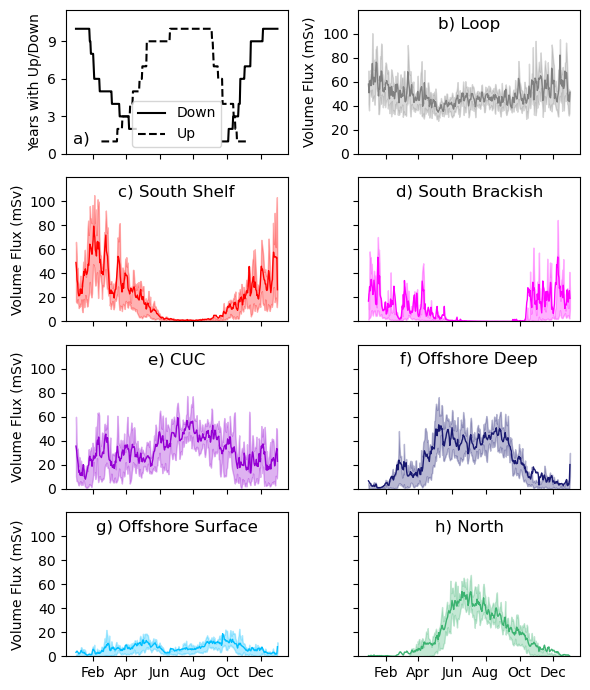

In [30]:
# using quantiles (previously std.. see github)
ymax=120000

fig, ax = plt.subplots(4,2, figsize=(6,7))

for axs in [ax[0,1],ax[1,0],ax[2,0],ax[3,0]]:
    axs.set_yticks([0,20000,40000,60000,80000,100000])
    axs.set_yticklabels(['0','20','40','60','80','100'])
    axs.set_ylabel('Volume Flux (mSv)')
for axs in [ax[1,1],ax[2,1],ax[3,1]]:
    axs.set_yticks([0,20000,40000,60000,80000,100000])
    axs.set_yticklabels([])

for i in range(4):
    for axs in ax[i]:
        axs.set_xticks([397-365,456-365,152,213,274,335]) #february 1, april 1, october 1, december 1
ax[3,0].set_xticklabels(['Feb','Apr','Jun','Aug','Oct','Dec'])
ax[3,1].set_xticklabels(['Feb','Apr','Jun','Aug','Oct','Dec'])


# count of the number of summers and winters with this date in the range
split=109
ax[0,0].plot(DWcount.jday[:split],DWcount['count'][:split],'k',label='Down')
ax[0,0].plot(DWcount.jday[split:],DWcount['count'][split:],'k')
ax[0,0].plot(UPcount.jday,UPcount['count'],'k--',label='Up')
ax[0,0].set_ylim([0,11.5])
ax[0,0].set_yticks([0,3,6,9])
ax[0,0].set_xticklabels([])
ax[0,0].set_ylabel("Years with Up/Down")
ax[0,0].legend()

# loop flow
ax[0,1].plot(list(set(loop.jday)),loop.groupby('jday')['transport'].mean(),'grey',lw=1)
ax[0,1].fill_between(list(set(loop.jday)),
                        loop.groupby('jday')['transport'].agg(lambda x: x.quantile(0.25)),
                        loop.groupby('jday')['transport'].agg(lambda x: x.quantile(0.75)),
                        color='grey',alpha=0.3)
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim([0,ymax])
ax[0,1].set_title('b) Loop',y=1,pad=-14)

# south shelf flow
ax[1,0].plot(list(set(south.jday)),south.groupby('jday')['transport'].mean(),'r',lw=1)
ax[1,0].fill_between(list(set(south.jday)),
                        south.groupby('jday')['transport'].agg(lambda x: x.quantile(0.25)),
                        south.groupby('jday')['transport'].agg(lambda x: x.quantile(0.75)),
                        color='r',alpha=0.3)
ax[1,0].set_xticklabels([])
ax[1,0].set_ylim([0,ymax])
ax[1,0].set_title('c) South Shelf',y=1,pad=-14)


# fresh flow
ax[1,1].plot(list(set(fresh.jday)),fresh.groupby('jday')['transport'].mean(),'magenta',lw=1)
ax[1,1].fill_between(list(set(fresh.jday)),
                        fresh.groupby('jday')['transport'].agg(lambda x: x.quantile(0.25)),
                        fresh.groupby('jday')['transport'].agg(lambda x: x.quantile(0.75)),
                        color='magenta',alpha=0.3)
ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])
ax[1,1].set_ylim([0,ymax])
ax[1,1].set_title('d) South Brackish',y=1,pad=-14)

# cuc flow
ax[2,0].plot(list(set(cuc.jday)),cuc.groupby('jday')['transport'].mean(),'darkviolet',lw=1)
ax[2,0].fill_between(list(set(cuc.jday)),
                        cuc.groupby('jday')['transport'].agg(lambda x: x.quantile(0.25)),
                        cuc.groupby('jday')['transport'].agg(lambda x: x.quantile(0.75)),
                        color='darkviolet',alpha=0.3)
ax[2,0].set_xticklabels([])
ax[2,0].set_ylim([0,ymax])
ax[2,0].set_title('e) CUC',y=1,pad=-14)

# offshore deep flow
ax[2,1].plot(list(set(offd.jday)),offd.groupby('jday')['transport'].mean(),'midnightblue',lw=1)
ax[2,1].fill_between(list(set(offd.jday)),
                        offd.groupby('jday')['transport'].agg(lambda x: x.quantile(0.25)),
                        offd.groupby('jday')['transport'].agg(lambda x: x.quantile(0.75)),
                        color='midnightblue',alpha=0.3)
ax[2,1].set_ylim([0,ymax])
ax[2,1].set_title('f) Offshore Deep',y=1,pad=-14)
ax[2,1].set_yticklabels([])
ax[2,1].set_xticklabels([])

# offshore surface flow
ax[3,0].plot(list(set(offs.jday)),offs.groupby('jday')['transport'].mean(),'deepskyblue',lw=1)
ax[3,0].fill_between(list(set(offs.jday)),
                        offs.groupby('jday')['transport'].agg(lambda x: x.quantile(0.25)),
                        offs.groupby('jday')['transport'].agg(lambda x: x.quantile(0.75)),
                        color='deepskyblue',alpha=0.3)
# ax[3,0].set_xticklabels([])
ax[3,0].set_ylim([0,ymax])
ax[3,0].set_title('g) Offshore Surface',y=1,pad=-14)


# north flow
ax[3,1].plot(list(set(north.jday)),north.groupby('jday')['transport'].mean(),'mediumseagreen',lw=1)
ax[3,1].fill_between(list(set(north.jday)),
                        north.groupby('jday')['transport'].agg(lambda x: x.quantile(0.25)),
                        north.groupby('jday')['transport'].agg(lambda x: x.quantile(0.75)),
                        color='mediumseagreen',alpha=0.3)
ax[3,1].set_ylim([0,ymax])
ax[3,1].set_title('h) North',y=1,pad=-14)
ax[3,1].set_yticklabels([])


# add letter markers to each figure 
ax[0,0].text(.03, .05, 'a)', ha='left', va='bottom', transform=ax[0,0].transAxes, fontsize=12)
# ax[0,1].text(.01, .95, 'b)', ha='left', va='top', transform=ax[0,1].transAxes, fontsize=12)
# ax[1,0].text(.01, .95, 'c)', ha='left', va='top', transform=ax[1,0].transAxes, fontsize=12)
# ax[1,1].text(.01, .95, 'd)', ha='left', va='top', transform=ax[1,1].transAxes, fontsize=12)
# ax[2,0].text(.01, .95, 'e)', ha='left', va='top', transform=ax[2,0].transAxes, fontsize=12)
# ax[2,1].text(.01, .95, 'f)', ha='left', va='top', transform=ax[2,1].transAxes, fontsize=12)
# ax[3,0].text(.01, .95, 'g)', ha='left', va='top', transform=ax[3,0].transAxes, fontsize=12)
# ax[3,1].text(.01, .95, 'h)', ha='left', va='top', transform=ax[3,1].transAxes, fontsize=12)



plt.tight_layout()
plt.savefig('/data1/bbeutel/LO_user/ariane/figures/total_dynamics.pdf')

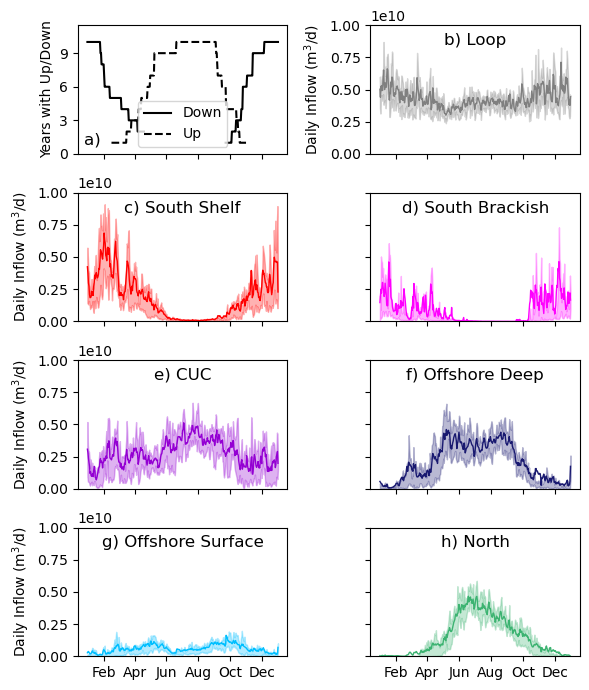

In [31]:
# daily volume of inflow instead of transport
ymax=10000000000

fig, ax = plt.subplots(4,2, figsize=(6,7))

for axs in [ax[0,1],ax[1,0],ax[2,0],ax[3,0]]:
    # axs.set_yticks([0,20000,40000,60000,80000,100000])
    # axs.set_yticklabels(['0','20','40','60','80','100'])
    axs.set_ylabel('Daily Inflow (m$^{3}$/d)')
# for axs in [ax[1,1],ax[2,1],ax[3,1]]:
    # axs.set_yticks([0,20000,40000,60000,80000,100000])
    # axs.set_yticklabels([])

for i in range(4):
    for axs in ax[i]:
        axs.set_xticks([397-365,456-365,152,213,274,335]) #february 1, april 1, october 1, december 1
ax[3,0].set_xticklabels(['Feb','Apr','Jun','Aug','Oct','Dec'])
ax[3,1].set_xticklabels(['Feb','Apr','Jun','Aug','Oct','Dec'])


# count of the number of summers and winters with this date in the range
split=109
ax[0,0].plot(DWcount.jday[:split],DWcount['count'][:split],'k',label='Down')
ax[0,0].plot(DWcount.jday[split:],DWcount['count'][split:],'k')
ax[0,0].plot(UPcount.jday,UPcount['count'],'k--',label='Up')
ax[0,0].set_ylim([0,11.5])
ax[0,0].set_yticks([0,3,6,9])
ax[0,0].set_xticklabels([])
ax[0,0].set_ylabel("Years with Up/Down")
ax[0,0].legend()

# loop flow
ax[0,1].plot(list(set(loop.jday)),loop.groupby('jday')['transport'].mean()*86400,'grey',lw=1)
ax[0,1].fill_between(list(set(loop.jday)),
                        loop.groupby('jday')['transport'].agg(lambda x: x.quantile(0.25))*86400,
                        loop.groupby('jday')['transport'].agg(lambda x: x.quantile(0.75))*86400,
                        color='grey',alpha=0.3)
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim([0,ymax])
ax[0,1].set_title('b) Loop',y=1,pad=-14)

# south shelf flow
ax[1,0].plot(list(set(south.jday)),south.groupby('jday')['transport'].mean()*86400,'r',lw=1)
ax[1,0].fill_between(list(set(south.jday)),
                        south.groupby('jday')['transport'].agg(lambda x: x.quantile(0.25))*86400,
                        south.groupby('jday')['transport'].agg(lambda x: x.quantile(0.75))*86400,
                        color='r',alpha=0.3)
ax[1,0].set_xticklabels([])
ax[1,0].set_ylim([0,ymax])
ax[1,0].set_title('c) South Shelf',y=1,pad=-14)


# fresh flow
ax[1,1].plot(list(set(fresh.jday)),fresh.groupby('jday')['transport'].mean()*86400,'magenta',lw=1)
ax[1,1].fill_between(list(set(fresh.jday)),
                        fresh.groupby('jday')['transport'].agg(lambda x: x.quantile(0.25))*86400,
                        fresh.groupby('jday')['transport'].agg(lambda x: x.quantile(0.75))*86400,
                        color='magenta',alpha=0.3)
ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])
ax[1,1].set_ylim([0,ymax])
ax[1,1].set_title('d) South Brackish',y=1,pad=-14)

# cuc flow
ax[2,0].plot(list(set(cuc.jday)),cuc.groupby('jday')['transport'].mean()*86400,'darkviolet',lw=1)
ax[2,0].fill_between(list(set(cuc.jday)),
                        cuc.groupby('jday')['transport'].agg(lambda x: x.quantile(0.25))*86400,
                        cuc.groupby('jday')['transport'].agg(lambda x: x.quantile(0.75))*86400,
                        color='darkviolet',alpha=0.3)
ax[2,0].set_xticklabels([])
ax[2,0].set_ylim([0,ymax])
ax[2,0].set_title('e) CUC',y=1,pad=-14)

# offshore deep flow
ax[2,1].plot(list(set(offd.jday)),offd.groupby('jday')['transport'].mean()*86400,'midnightblue',lw=1)
ax[2,1].fill_between(list(set(offd.jday)),
                        offd.groupby('jday')['transport'].agg(lambda x: x.quantile(0.25))*86400,
                        offd.groupby('jday')['transport'].agg(lambda x: x.quantile(0.75))*86400,
                        color='midnightblue',alpha=0.3)
ax[2,1].set_ylim([0,ymax])
ax[2,1].set_title('f) Offshore Deep',y=1,pad=-14)
ax[2,1].set_yticklabels([])
ax[2,1].set_xticklabels([])

# offshore surface flow
ax[3,0].plot(list(set(offs.jday)),offs.groupby('jday')['transport'].mean()*86400,'deepskyblue',lw=1)
ax[3,0].fill_between(list(set(offs.jday)),
                        offs.groupby('jday')['transport'].agg(lambda x: x.quantile(0.25))*86400,
                        offs.groupby('jday')['transport'].agg(lambda x: x.quantile(0.75))*86400,
                        color='deepskyblue',alpha=0.3)
# ax[3,0].set_xticklabels([])
ax[3,0].set_ylim([0,ymax])
ax[3,0].set_title('g) Offshore Surface',y=1,pad=-14)


# north flow
ax[3,1].plot(list(set(north.jday)),north.groupby('jday')['transport'].mean()*86400,'mediumseagreen',lw=1)
ax[3,1].fill_between(list(set(north.jday)),
                        north.groupby('jday')['transport'].agg(lambda x: x.quantile(0.25))*86400,
                        north.groupby('jday')['transport'].agg(lambda x: x.quantile(0.75))*86400,
                        color='mediumseagreen',alpha=0.3)
ax[3,1].set_ylim([0,ymax])
ax[3,1].set_title('h) North',y=1,pad=-14)
ax[3,1].set_yticklabels([])


# add letter markers to each figure 
ax[0,0].text(.03, .05, 'a)', ha='left', va='bottom', transform=ax[0,0].transAxes, fontsize=12)
# ax[0,1].text(.01, .95, 'b)', ha='left', va='top', transform=ax[0,1].transAxes, fontsize=12)
# ax[1,0].text(.01, .95, 'c)', ha='left', va='top', transform=ax[1,0].transAxes, fontsize=12)
# ax[1,1].text(.01, .95, 'd)', ha='left', va='top', transform=ax[1,1].transAxes, fontsize=12)
# ax[2,0].text(.01, .95, 'e)', ha='left', va='top', transform=ax[2,0].transAxes, fontsize=12)
# ax[2,1].text(.01, .95, 'f)', ha='left', va='top', transform=ax[2,1].transAxes, fontsize=12)
# ax[3,0].text(.01, .95, 'g)', ha='left', va='top', transform=ax[3,0].transAxes, fontsize=12)
# ax[3,1].text(.01, .95, 'h)', ha='left', va='top', transform=ax[3,1].transAxes, fontsize=12)



plt.tight_layout()
# plt.savefig('/data1/bbeutel/LO_user/ariane/figures/total_dynamics.pdf')

In [32]:
Uloop

[0     NaN
 1     NaN
 2     NaN
 3     NaN
 4     NaN
        ..
 257   NaN
 258   NaN
 259   NaN
 260   NaN
 261   NaN
 Name: transport_2014, Length: 262, dtype: float64,
 0     NaN
 1     NaN
 2     NaN
 3     NaN
 4     NaN
        ..
 257   NaN
 258   NaN
 259   NaN
 260   NaN
 261   NaN
 Name: transport_2015, Length: 262, dtype: float64,
 0     NaN
 1     NaN
 2     NaN
 3     NaN
 4     NaN
        ..
 257   NaN
 258   NaN
 259   NaN
 260   NaN
 261   NaN
 Name: transport_2016, Length: 262, dtype: float64,
 0     NaN
 1     NaN
 2     NaN
 3     NaN
 4     NaN
        ..
 257   NaN
 258   NaN
 259   NaN
 260   NaN
 261   NaN
 Name: transport_2017, Length: 262, dtype: float64,
 0     NaN
 1     NaN
 2     NaN
 3     NaN
 4     NaN
        ..
 257   NaN
 258   NaN
 259   NaN
 260   NaN
 261   NaN
 Name: transport_2018, Length: 262, dtype: float64,
 0               NaN
 1               NaN
 2               NaN
 3               NaN
 4               NaN
            ...     
 257    5